# <hr style="clear: both" />

# Running Spark in YARN-client mode

This notebook demonstrates how to set up a SparkContext that uses SURFsara's Hadoop cluster: [YARN resourcemanager](http://head05.hathi.surfsara.nl:8088/cluster) (note you will need to be authenticated via kerberos on your machine to visit the resourcemanager link) for executors.

First initialize kerberos via a Jupyter terminal. 
In the terminal execute: <BR>
<i>kinit -k -t data/robertop.keytab robertop@CUA.SURFSARA.NL</i><BR>
Print your credentials:


In [1]:
! klist

Ticket cache: FILE:/tmp/krb5cc_1000
Default principal: robertop@CUA.SURFSARA.NL

Valid starting       Expires              Service principal
06/03/2016 07:11:25  06/04/2016 07:11:25  krbtgt/CUA.SURFSARA.NL@CUA.SURFSARA.NL
	renew until 06/03/2016 07:11:25


In [2]:
! hdfs dfs -ls 
execfile('../spark-scripts/bullet.py')

Found 5 items
drwx------   - robertop hdfs          0 2016-05-26 06:00 .Trash
drwxr-xr-x   - robertop hdfs          0 2016-06-03 07:12 .sparkStaging
drwx------   - robertop hdfs          0 2016-04-06 15:54 .staging
drwxr-xr-x   - robertop hdfs          0 2016-05-25 06:28 mattia
drwxr-xr-x   - robertop hdfs          0 2016-04-13 10:00 recsys2016Competition


Verify that we can browse HDFS:

Next initialize Spark. Note that the code below starts a job on the Hadoop cluster that will remain running while the notebook is active. Please close and halt the notebook when you are done. Starting the SparkContext can take a little longer. You can check the YARN resourcemanager to see the current status/usage of the cluster.

In [3]:
import os
os.environ['PYSPARK_PYTHON'] = '/usr/local/bin/python2.7'

HDFS_PATH = "hdfs://hathi-surfsara"

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sconf = SparkConf(False)

sconf.setAppName('Results')

# Master is now yarn-client. The YARN and hadoop config is read from the environment
sconf.setMaster("yarn-client")

# You can control many Spark settings via the SparkConf. This determines the amount of executors on the cluster:
sconf.set("spark.executor.instances", "10")
#sconf.set("spark.executor.memory", "10g")

# UFW (firewall) is active on the VM. We explicitly opened these ports and Spark should not bind to random ports:
sconf.set("spark.driver.port", 51800)
sconf.set("spark.fileserver.port", 51801)
sconf.set("spark.broadcast.port", 51802)
sconf.set("spark.replClassServer.port", 51803)
sconf.set("spark.blockManager.port", 51804)
sconf.set("spark.authenticate", True)
sconf.set("spark.yarn.keytab", "/home/jovyan/work/data/robertop.keytab")
sconf.set("spark.yarn.access.namenodes", HDFS_PATH + ":8020")

try:
    sc = SparkContext(conf=sconf)
    sqlCtx = SQLContext(sc) 
    sendNotificationToMattia("Spark Context", str(sc))
except Exception, err:
    sendNotificationToMattia("Fuck you!", str(err)) 
    print str(err)

# <hr style="clear: both" />

# Now you can run your code


# Load all the results

In [36]:
import json

DATA_PATH = '/home/jovyan/work/data/mattia/resultsNew'


metrics = ['recall@N', 'precision@N']
ALGOS = ['original', 'jaccardBase9', 'collaborative/min_j_25_avgShrink2_higherMean', 'MF_Sessions/factors100/iterations10']

algo_names = ['Implicit Playlists (IPR)', 'IPR + Jaccard 0.9', 'IPR + Collaborative ', 'ALS_MF_100f_10i']

application = ['full', 'eval']
eval_type = ['ideal', 'loss', 'flat']

results = {}


#Load original results
algo = ALGOS[0]
results[algo] = {}
for m in metrics:
    with open(os.path.join(DATA_PATH, algo, m), 'r') as f:
        res = []
        for line in f.readlines() :
            res.append(json.loads(line))
    results[algo][m] = res
    

#Load original results
algo = ALGOS[-1]
results[algo] = {}
for m in metrics:
    with open(os.path.join(DATA_PATH, algo, m), 'r') as f:
        res = []
        for line in f.readlines() :
            res.append(json.loads(line))
    results[algo][m] = res
    
    
#Load Clustering result
for algo in ALGOS[1:-1]:
    results[algo] = {}
    
    for a in application:
        results[algo][a] = {}
        eval_type = ['ideal', 'loss', 'flat'] if a == 'full' else ['ideal', 'loss']
        
        for e in eval_type:
            results[algo][a][e] = {}
            
            for m in metrics:
                res = []
                with open(os.path.join(DATA_PATH, algo, a, e, m), 'r') as f:
                    for line in f.readlines() :
                        res.append(json.loads(line))
                
                results[algo][a][e][m] = res

In [37]:
def extract_results(x):
    new_results = {}
    for i in x:
        evaluation = i['evaluation']
        N = evaluation['N']
        values = evaluation['value']
        new_results[N] = values
    return new_results

font_title = {'family': 'serif',
                   'weight': 'normal',
                   'verticalalignment': 'bottom',
                   'size': 18}  


font_labels = {'family': 'serif',
                   'weight': 'normal',
                   'size': 14}   

# Performances Exploding Clusters

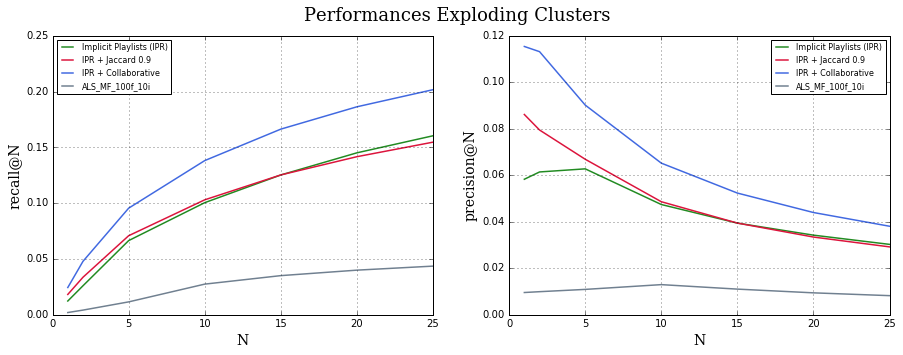

In [46]:
from matplotlib import pyplot as plt
%matplotlib inline

N = [1, 2, 5, 10, 15, 20, 25]

LINE_W = 1.5

#Compare Performances of Orginal VS Cluster Flat
cluster_algos = ALGOS[1:-1]

plt.figure(1, figsize=(15,5))
plt.suptitle("Performances Exploding Clusters", fontdict = font_title, fontsize=14)

colors = ['crimson', 'royalblue', 'limegreen', 'b', 'darkgreen', 'forestgreen']

for j,m in enumerate(metrics):
    plt.subplot(121+ j)
    
    original_result = results['original']
    original = [ extract_results(original_result[m])[i] for i in N ]
    plt.plot(N, original, 'forestgreen', linewidth = LINE_W)
    
    for i,alg in enumerate(cluster_algos):
        flat_results = results[alg]['full']['flat'] 
        clust_flat = [ extract_results(flat_results[m])[k] for k in N ]
        
        plt.ylabel(m ,fontdict = font_labels)
        plt.xlabel('N', fontdict = font_labels)
        
        plt.plot(N, clust_flat, colors[i], linewidth = LINE_W)
    
    mf_result = results[ALGOS[-1]]
    mf = [ extract_results(mf_result[m])[i] for i in N ]
    plt.plot(N, mf, 'slategrey', linewidth = LINE_W)

    legend_names = algo_names
    
    plt.legend(legend_names, fontsize = 8, loc=2 - j)

    plt.grid(True)
plt.show()


# Compare Differences in Train - Eval

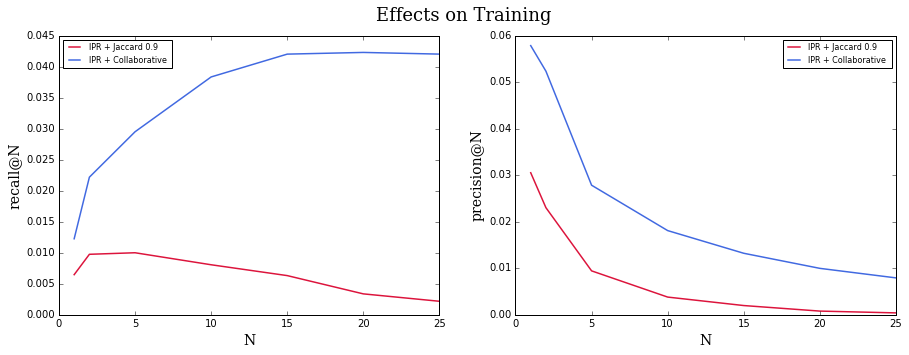

In [44]:
plt.figure(1+i, figsize=(15,5))
plt.suptitle("Effects on Training", fontdict = font_title, fontsize = 16)

for j,m in enumerate(metrics):
    
    plt.subplot(121 + j)
    plt.ylabel(m ,fontdict = font_labels)
    plt.xlabel('N', fontdict = font_labels)
    
    for i,alg in enumerate(cluster_algos):
        full_ideal_results = results[alg]['full']['ideal']
        eval_ideal_results = results[alg]['eval']['ideal']
    
        difference = [extract_results(full_ideal_results[m])[k] - extract_results(eval_ideal_results[m])[k] for k in N]        
        plt.plot(N, difference, colors[i], linewidth = LINE_W)
        

    plt.legend(legend_names[1:], fontsize = 8, loc=2 - j)

plt.show()

# Uncertainty

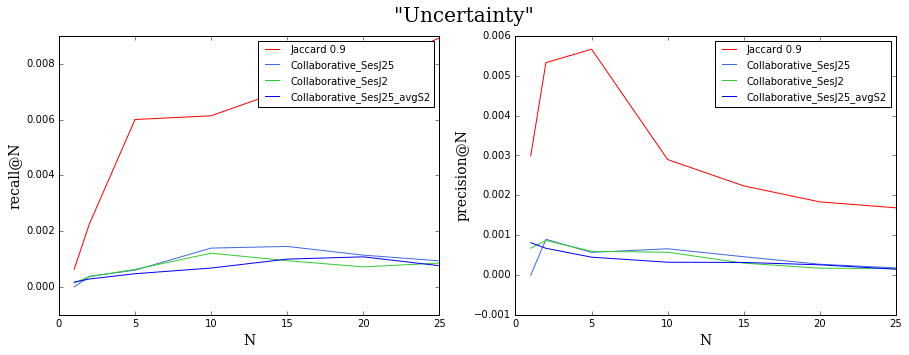

In [31]:
plt.figure(1+i, figsize=(15,5))
plt.suptitle('''"Uncertainty"''', fontdict = font_title, fontsize = 16)

colors = ['forestgreen','royalblue','crimson']
colors = ['red', 'royalblue', 'limegreen', 'b', 'darkgreen', 'forestgreen']

for j,m in enumerate(metrics):
    
    plt.subplot(121 + j)
    plt.ylabel(m ,fontdict = font_labels)
    plt.xlabel('N', fontdict = font_labels)
    
    for i,alg in enumerate(cluster_algos[:4]):
        full_ideal_results = results[alg]['full']['ideal']
        flat_results = results[alg]['full']['flat']
    
        difference = [extract_results(full_ideal_results[m])[k] - extract_results(flat_results[m])[k] for k in N]        
        plt.plot(N, difference, colors[i], linewidth = LINE_W)

    plt.legend(algo_names[1:], fontsize = 10, loc=1)

plt.show()